In [146]:
# Install the approxposterior package from https://dflemin3.github.io/approxposterior/tutorial.html 
# before you run this notebook

import numpy as np
import matplotlib.pyplot as plt
import emcee
from scipy.optimize import minimize
import corner

#Our expensive physics simulation
import run_simple_energy_loss

import ptemcee
import subprocess
import pandas as pd

from joblib import Parallel, delayed

# Gaussian Process emulation
from sklearn.gaussian_process import GaussianProcessRegressor as GPR #for using Gaussian Processes
from sklearn.gaussian_process import kernels #same
from sklearn.preprocessing import StandardScaler #useful for scaling data

**Data**

---

First, we generate data from our jet energy loss simulations and assume  indepedent, Gaussian errors, for the measurement of $R_{AA}$.

In [125]:
simulation=run_simple_energy_loss.run_simulation

pT_range = (1, 10, 10) # Compute more observable than needed to avoid boundary unstabilities.
pT_obs = [3, 5, 7] # p_T Observables we will use for the analysis
prior_ranges= {'alpha_s':(0.05,0.5), 'exponent_inel':(-3,3), 'exponent_el':(-3,3),'scale_inel':(0.01,0.5), 'scale_el':(0.01,0.5)}
true_values= {'alpha_s': 0.2, 'exponent_inel': -1, 'exponent_el': 1, 'scale_inel':0.2, 'scale_el':0.2}

mean_values= {'alpha_s': 0.19, 'exponent_inel': 0.06, 'exponent_el': 0, 'scale_inel':0.24, 'scale_el':0.27}
meanslhsgp = np.array([mean_values['alpha_s'],  mean_values['exponent_inel'],
                 mean_values['exponent_el'],mean_values['scale_inel'],mean_values['scale_el']]).reshape(1,-1)

# We will generate observables for these model parameter values and consider them as experimental data
truth = np.array([true_values['alpha_s'],  true_values['exponent_inel'],
                 true_values['exponent_el'],true_values['scale_inel'],true_values['scale_el']]).reshape(1,-1)

In [126]:
mode_values= {'alpha_s': 0.19, 'exponent_inel': -1, 'exponent_el': -1, 'scale_inel':0.2, 'scale_el':0.2}
modeslhsgp = np.array([mode_values['alpha_s'],  mode_values['exponent_inel'],
                 mode_values['exponent_el'],mode_values['scale_inel'],mode_values['scale_el']]).reshape(1,-1)
mode_points = simulation(modeslhsgp, *pT_range)[:,pT_obs]

Working on 1/1 design


In [ ]:
# Set seed for reproducibility.
seed = 42
np.random.seed(seed)

# Generate some synthetic data from the model.
x = np.array(pT_obs)
N = len(x)
obserr = 0.05 # Amplitude of noise term
obs = simulation(truth, *pT_range)[:,pT_obs] # True model
obs += obserr * np.random.randn(N) # Add some random noise

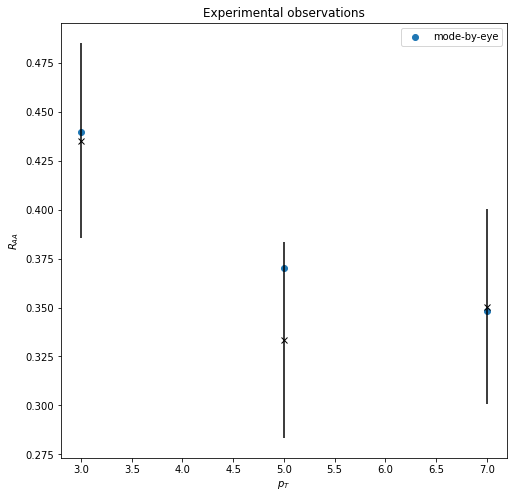

In [127]:
# Now plot it to see what the data looks like
fig, ax = plt.subplots(figsize=(8,8))

ax.errorbar(x.flatten(), obs.flatten(), yerr=obserr, fmt="xk", capsize=0)
ax.scatter(x.flatten(), mode_points.flatten(),label='mode-by-eye')
#ax.plot(x.flatten(), obs.flatten(), "k", alpha=0.3, lw=3)
#ax.set_xlim(0, 10)
ax.set_xlabel(r"$p_T$")
ax.set_ylabel(r"$R_{AA}$")
ax.set_title('Experimental observations')
plt.legend()
plt.show()

### Now introduce LHS and train emulators.

In [7]:
def generate_lhs(npoints, ndim, seed):
    """
    Generate a maximin Latin-hypercube sample (LHS) with the given number of
    points, dimensions, and random seed.
    
    Reproduced from js-sims-bayes
    """
    print(
        'generating maximin LHS: '
        'npoints = %d, ndim = %d, seed = %d'\
        % (npoints, ndim, seed)
    )

    print('generating using R')
    proc = subprocess.run(
        ['R', '--slave'],
        input="""
        library('lhs')
        set.seed({})
        write.table(maximinLHS({}, {}), col.names=FALSE, row.names=FALSE)
        """.format(seed, npoints, ndim).encode(),
        stdout=subprocess.PIPE,
        check=True
    )

    lhs = np.array(
        [l.split() for l in proc.stdout.splitlines()],
        dtype=float
    )

    return lhs

In [47]:
ndim = 5
npoints = 100#10*ndim # 10*d
design = generate_lhs(npoints,ndim,1691)
design_scaled = np.zeros(design.shape)

# do this just roughly for now and improve later
design_scaled[:,0] = design[:,0]*(prior_ranges['alpha_s'][1]-prior_ranges['alpha_s'][0])+prior_ranges['alpha_s'][0]
design_scaled[:,1] = design[:,1]*(prior_ranges['exponent_inel'][1]-prior_ranges['exponent_inel'][0])+prior_ranges['exponent_inel'][0]
design_scaled[:,2] = design[:,2]*(prior_ranges['exponent_el'][1]-prior_ranges['exponent_el'][0])+prior_ranges['exponent_el'][0]
design_scaled[:,3] = design[:,3]*(prior_ranges['scale_inel'][1]-prior_ranges['scale_inel'][0])+prior_ranges['scale_inel'][0]
design_scaled[:,4] = design[:,4]*(prior_ranges['scale_el'][1]-prior_ranges['scale_el'][0])+prior_ranges['scale_el'][0]


generating maximin LHS: npoints = 100, ndim = 5, seed = 1691
generating using R


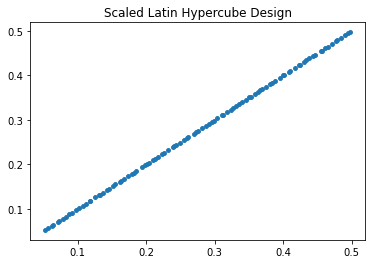

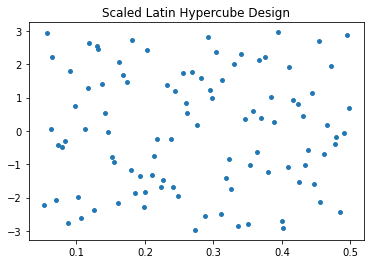

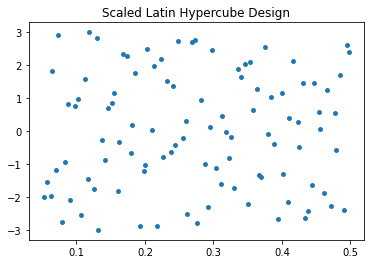

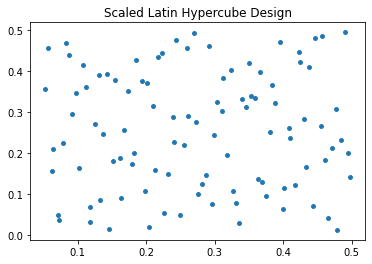

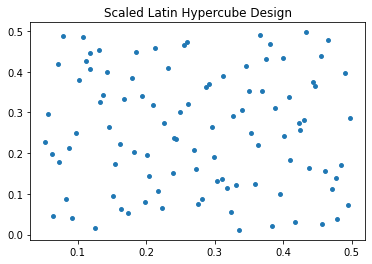

In [48]:
for i in range(ndim): # some quick visualizations to check on the design ranges
    plt.figure()
    plt.scatter(design_scaled[:,0],design_scaled[:,i],s=15)

    plt.title('Scaled Latin Hypercube Design')

    plt.show()

In [56]:
# perform model calculations at design points
# single core option
#design_calculations = np.array([simulation(dp.reshape(1,-1), *pT_range)[:,pT_obs] for dp in design_scaled])

# parallel option
cores = 4
designcalcs=Parallel(n_jobs=cores)(delayed(simulation)(dp.reshape(1,-1), *pT_range) for dp in design_scaled)

In [144]:
design_calculations=np.array([a[:,pT_obs] for a in designcalcs])

## Identifies where there was a timeout; need to rerun these points
designcalculations_i = (design_calculations==[[0,0,0]]).reshape(-1,3)
designcalcs_index = [x.any() for x in designcalculations_i]
failed_points = design_scaled[designcalcs_index]
print('failed design points: ',failed_points)

In [ ]:
# attempt to recalculate failed points
failed_recalcs = Parallel(n_jobs=cores)(delayed(simulation)(dp.reshape(1,-1), *pT_range) for dp in failed_points)

In [ ]:
# Overwrite previously failed points
design_calculations[designcalcs_index] = failed_recalcs

In [66]:
design_pts = np.array([pT_obs for i in range(design_calculations.shape[0])])

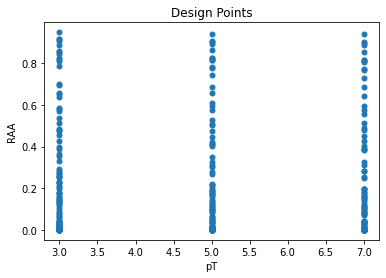

In [67]:
# quick visualization of the calculations
plt.figure()

plt.errorbar(design_pts,design_calculations,yerr=0,fmt='.',ms=10)

plt.title('Design Points')
plt.xlabel('pT')
plt.ylabel('RAA')

plt.show()

### Train the GP

In [68]:
# size of possible variation of parameters
ptp = np.array([prior_ranges['alpha_s'][1],prior_ranges['exponent_inel'][1],prior_ranges['exponent_el'][1],prior_ranges['scale_inel'][1],prior_ranges['scale_el'][1]])\
-np.array([prior_ranges['alpha_s'][0],prior_ranges['exponent_inel'][0],prior_ranges['exponent_el'][0],prior_ranges['scale_inel'][0],prior_ranges['scale_el'][0]])

#Squared Exponential Kernel
rbf_kern = 1. * kernels.RBF(
                      length_scale=ptp,
                      length_scale_bounds=np.outer(ptp, (1e-2, 1e2)),
                      )
#This is a white noise kernel for finite statistical accuracy
white_kern = kernels.WhiteKernel(
                         noise_level=.1,
                         noise_level_bounds=(1e-2, 1e1)
                        )

#kernel is the sum of the Sq. Exponential and White Noise kernels
my_kernel = (rbf_kern + white_kern) 

In [69]:
#first scale our observables 
model_y_copy = design_calculations.copy()
scaler = StandardScaler(copy=True).fit(model_y_copy.reshape(-1, 3))
scaled_model_y = scaler.transform(design_calculations.reshape(-1, 3), copy=True) # the scaled model outputs

In [70]:
model_y_pt0 = model_y_copy.reshape(-1,3)[:,0]
model_y_pt1 = model_y_copy.reshape(-1,3)[:,1]
model_y_pt2 = model_y_copy.reshape(-1,3)[:,2]

scaler_0 = StandardScaler(copy=True).fit(model_y_pt0.reshape(-1, 1)) 
scaler_1 = StandardScaler(copy=True).fit(model_y_pt1.reshape(-1, 1)) 
scaler_2 = StandardScaler(copy=True).fit(model_y_pt2.reshape(-1, 1)) 

scaled_model_y0 = scaler_0.transform(design_calculations.reshape(-1,3)[:,0].reshape(-1, 1),copy=True)
scaled_model_y1 = scaler_1.transform(design_calculations.reshape(-1,3)[:,1].reshape(-1, 1),copy=True)
scaled_model_y2 = scaler_2.transform(design_calculations.reshape(-1,3)[:,2].reshape(-1, 1),copy=True)

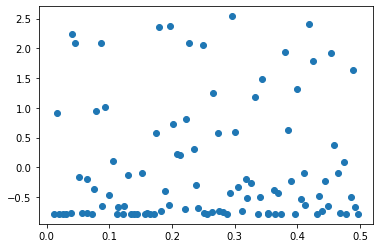

In [71]:
plt.figure()
plt.scatter(design_scaled[:,4],scaled_model_y2)
plt.show()

In [72]:
#maximizing the GP likelihood proceeds in an iterative process,
#beginning with a random seed. 
#We want to be sure we find a global max., so we restart it several times
nrestarts=20

#define our Gaussian process, and fit it to the hydro model calculations
my_gp0 = GPR(kernel=my_kernel,
         alpha=0.01, # the nugget, to stabilize matrix inversions
         n_restarts_optimizer=nrestarts, 
         ).fit(design_scaled, scaled_model_y0)

my_gp1 = GPR(kernel=my_kernel,
         alpha=0.01, # the nugget, to stabilize matrix inversions
         n_restarts_optimizer=nrestarts, 
         ).fit(design_scaled, scaled_model_y1)

my_gp2 = GPR(kernel=my_kernel,
         alpha=0.01, # the nugget, to stabilize matrix inversions
         n_restarts_optimizer=nrestarts, 
         ).fit(design_scaled, scaled_model_y2)

/home/mheffernan/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/mheffernan/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/mheffernan/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn

In [73]:
def emu_predict0(X):
    scaled_y, scaled_dy = my_gp0.predict(X, return_std=True, return_cov=False)
    y = scaler_0.inverse_transform(scaled_y)
    dy = scaled_dy* scaler_0.scale_
    return y, dy

def emu_predict1(X):
    scaled_y, scaled_dy = my_gp1.predict(X, return_std=True, return_cov=False)
    y = scaler_1.inverse_transform(scaled_y)
    dy = scaled_dy* scaler_1.scale_
    return y, dy

def emu_predict2(X):
    scaled_y, scaled_dy = my_gp2.predict(X, return_std=True, return_cov=False)
    y = scaler_2.inverse_transform(scaled_y)
    dy = scaled_dy* scaler_2.scale_
    return y, dy

<ipython-input-74-f3e3b91775f8>:25: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(True)


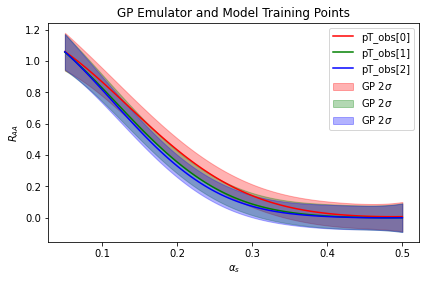

In [74]:
#make a regular grid to plot our Emulator predictions
n_plot_pts = 100
test_points = np.array([[x,true_values['exponent_inel'],
                 true_values['exponent_el'],true_values['scale_inel'],true_values['scale_el']] for x in np.linspace(prior_ranges['alpha_s'][0],prior_ranges['alpha_s'][1],n_plot_pts)])

#get the GP Emulator's predictions of both the mean and std. deviation
gp_y0, gp_dy0 = emu_predict0(test_points)
gp_y1, gp_dy1 = emu_predict1(test_points)
gp_y2, gp_dy2 = emu_predict2(test_points)

plt.plot(test_points[:,0], gp_y0[:,0], color='red', label='pT_obs[0]')
plt.plot(test_points[:,0], gp_y1[:,0], color='green', label='pT_obs[1]')
plt.plot(test_points[:,0], gp_y2[:,0], color='blue', label='pT_obs[2]')
plt.fill_between(test_points[:,0], y1 = gp_y0[:,0] - 2.*gp_dy0, y2 = gp_y0[:,0] + 2.*gp_dy0, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='red')
plt.fill_between(test_points[:,0], y1 = gp_y1[:,0] - 2.*gp_dy1, y2 = gp_y1[:,0] + 2.*gp_dy1, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='green')
plt.fill_between(test_points[:,0], y1 = gp_y2[:,0] - 2.*gp_dy2, y2 = gp_y2[:,0] + 2.*gp_dy2, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='blue')

plt.xlabel(r'$\alpha_s$')
plt.ylabel(r'$R_{AA}$')
plt.title(r'GP Emulator and Model Training Points')
plt.legend()
plt.tight_layout(True)

plt.show()

<ipython-input-75-e4891ba1819c>:25: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(True)


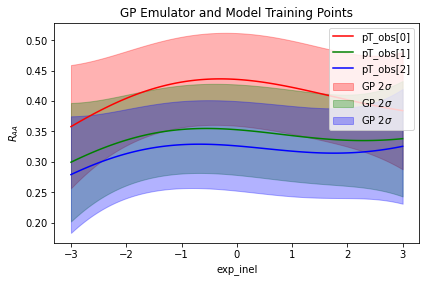

In [75]:
#make a regular grid to plot our Emulator predictions
n_plot_pts = 100
test_points = np.array([[true_values['alpha_s'],x,
                 true_values['exponent_el'],true_values['scale_inel'],true_values['scale_el']] for x in np.linspace(prior_ranges['exponent_inel'][0],prior_ranges['exponent_inel'][1],n_plot_pts)])

#get the GP Emulator's predictions of both the mean and std. deviation
gp_y0, gp_dy0 = emu_predict0(test_points)
gp_y1, gp_dy1 = emu_predict1(test_points)
gp_y2, gp_dy2 = emu_predict2(test_points)

plt.plot(test_points[:,1], gp_y0[:,0], color='red', label='pT_obs[0]')
plt.plot(test_points[:,1], gp_y1[:,0], color='green', label='pT_obs[1]')
plt.plot(test_points[:,1], gp_y2[:,0], color='blue', label='pT_obs[2]')
plt.fill_between(test_points[:,1], y1 = gp_y0[:,0] - 2.*gp_dy0, y2 = gp_y0[:,0] + 2.*gp_dy0, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='red')
plt.fill_between(test_points[:,1], y1 = gp_y1[:,0] - 2.*gp_dy1, y2 = gp_y1[:,0] + 2.*gp_dy1, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='green')
plt.fill_between(test_points[:,1], y1 = gp_y2[:,0] - 2.*gp_dy2, y2 = gp_y2[:,0] + 2.*gp_dy2, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='blue')

plt.xlabel(r'exp_inel')
plt.ylabel(r'$R_{AA}$')
plt.title(r'GP Emulator and Model Training Points')
plt.legend()
plt.tight_layout(True)

plt.show()

<ipython-input-76-7ca74fbaa7ef>:25: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(True)


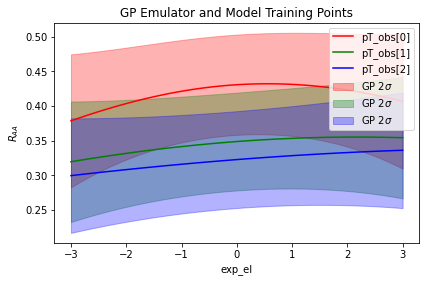

In [76]:
#make a regular grid to plot our Emulator predictions
n_plot_pts = 100
test_points = np.array([[true_values['alpha_s'],true_values['exponent_inel'],
                 x,true_values['scale_inel'],true_values['scale_el']] for x in np.linspace(prior_ranges['exponent_el'][0],prior_ranges['exponent_el'][1],n_plot_pts)])

#get the GP Emulator's predictions of both the mean and std. deviation
gp_y0, gp_dy0 = emu_predict0(test_points)
gp_y1, gp_dy1 = emu_predict1(test_points)
gp_y2, gp_dy2 = emu_predict2(test_points)

plt.plot(test_points[:,2], gp_y0[:,0], color='red', label='pT_obs[0]')
plt.plot(test_points[:,2], gp_y1[:,0], color='green', label='pT_obs[1]')
plt.plot(test_points[:,2], gp_y2[:,0], color='blue', label='pT_obs[2]')
plt.fill_between(test_points[:,2], y1 = gp_y0[:,0] - 2.*gp_dy0, y2 = gp_y0[:,0] + 2.*gp_dy0, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='red')
plt.fill_between(test_points[:,2], y1 = gp_y1[:,0] - 2.*gp_dy1, y2 = gp_y1[:,0] + 2.*gp_dy1, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='green')
plt.fill_between(test_points[:,2], y1 = gp_y2[:,0] - 2.*gp_dy2, y2 = gp_y2[:,0] + 2.*gp_dy2, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='blue')

plt.xlabel(r'exp_el')
plt.ylabel(r'$R_{AA}$')
plt.title(r'GP Emulator and Model Training Points')
plt.legend()
plt.tight_layout(True)

plt.show()

At this point, we should be fairly satisfied with the performance of the emulators and we can move on to inference directly.

### Now move on to inference: update likelihood function with GP error!

In [92]:
# Define the loglikelihood function
def logLikelihood(theta, x, obs, obserr):
  
    # Model parameters
    theta = np.array(theta)
    
    #alpha_s, mD_factor, exponent_inel, exponent_el = theta
    alpha_s, exp_inel, exp_el, sc_inel, sc_el = theta
    design = np.array([alpha_s, exp_inel, exp_el, sc_inel, sc_el]).reshape(1,-1)
    
    # Model predictions given parameters
    
    model = np.array([emu_predict0(design),emu_predict1(design),emu_predict2(design)],dtype=object)
    modelerr = model[:,1]
    model = model[:,0]
    
    # Likelihood of data given model parameters

    term2 = 0.5*(2*np.pi*np.sqrt(np.sum(obserr**2+modelerr.flatten()**2)))
    return -0.5*np.sum((obs.flatten()-model.flatten())**2/(obserr**2+modelerr.flatten()**2)) - term2

In [93]:
logLikelihood(truth.flatten(),x,obs,obserr)

-0.456148984575104

In [95]:
# Define the logprior function
def logPrior(theta):
    
    # Model parameters
    theta = np.array(theta)
    alpha_s, exp_inel, exp_el, sc_inel, sc_el = theta 
    
    # Probability of model parameters: flat prior
    if prior_ranges['alpha_s'][0] < alpha_s < prior_ranges['alpha_s'][1] \
        and prior_ranges['exponent_inel'][0] < exp_inel < prior_ranges['exponent_inel'][1] \
        and prior_ranges['exponent_el'][0] < exp_el < prior_ranges['exponent_el'][1]\
        and prior_ranges['scale_inel'][0] < sc_inel < prior_ranges['scale_inel'][1] \
        and prior_ranges['scale_el'][0] < sc_el < prior_ranges['scale_el'][1]:
        return 0.0
    return -np.inf

In [96]:
# Define logprobability function: l(D|theta) * p(theta)
# Note: use this for emcee, not approxposterior!
def logposterior(theta, x, obs, obserr):
        
    lp = logPrior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + logLikelihood(theta, x, obs, obserr)

In [97]:
ntemps = 25
Tmax = 1e3

nwalkers = 50 #guidance is 10*d
ndim = 5
nburnin = 2000
niterations= 5000
nthin = 1#0 # only record every nthin iteration

nthreads = 4

min_theta = np.array([prior_ranges['alpha_s'][0],prior_ranges['exponent_inel'][0],prior_ranges['exponent_el'][0],prior_ranges['scale_inel'][0],prior_ranges['scale_el'][0]])
max_theta = np.array([prior_ranges['alpha_s'][1],prior_ranges['exponent_inel'][1],prior_ranges['exponent_el'][1],prior_ranges['scale_inel'][1],prior_ranges['scale_el'][1]])

# Data and uncertainties that we use to condition our model
args = (x, obs, obserr) # recall x = np.array(pT_obs)

ptsampler=ptemcee.Sampler(nwalkers, ndim, logLikelihood, logPrior, ntemps, 
                  threads=nthreads, Tmax=Tmax, loglargs=args)

# Making the sampling multi-threaded is as simple as adding the threads=Nthreads 
# argument to PTSampler. 

# First, we run the sampler for 1000 burn-in iterations:
pos0 = np.random.uniform(min_theta, max_theta, (ntemps, nwalkers, ndim))

print("Running burn-in phase")
for p, lnprob, lnlike in ptsampler.sample(pos0, iterations=nburnin,adapt=True):
    pass
ptsampler.reset()

print("Running MCMC chains")
#Now we sample for nwalkers*niterations, recording every nthin-th sample:
for p, lnprob, lnlike in ptsampler.sample(p, iterations=niterations, thin=nthin,adapt=True):
    pass 

print('Done MCMC')

mean_acc_frac = np.mean(ptsampler.acceptance_fraction)
print(f"Mean acceptance fraction: {mean_acc_frac:.3f}",
      f"(in total {nwalkers*niterations} steps)")

Running burn-in phase
Running MCMC chains
Done MCMC
Mean acceptance fraction: 0.281 (in total 250000 steps)


Process ForkPoolWorker-32:
Process ForkPoolWorker-34:
Process ForkPoolWorker-33:
Process ForkPoolWorker-31:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mheffernan/anaconda3/lib/python3.8/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
  File "/home/mheffernan/anaconda3/lib/python3.8/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
  File "/home/mheffernan/anaconda3/lib/python3.8/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
  File "/home/mheffernan/anaconda3/lib/python3.8/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
  File "/home/mheffernan/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mheffernan/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  

In [98]:
chain = ptsampler.chain[0, :, :, :].reshape((-1, ndim))

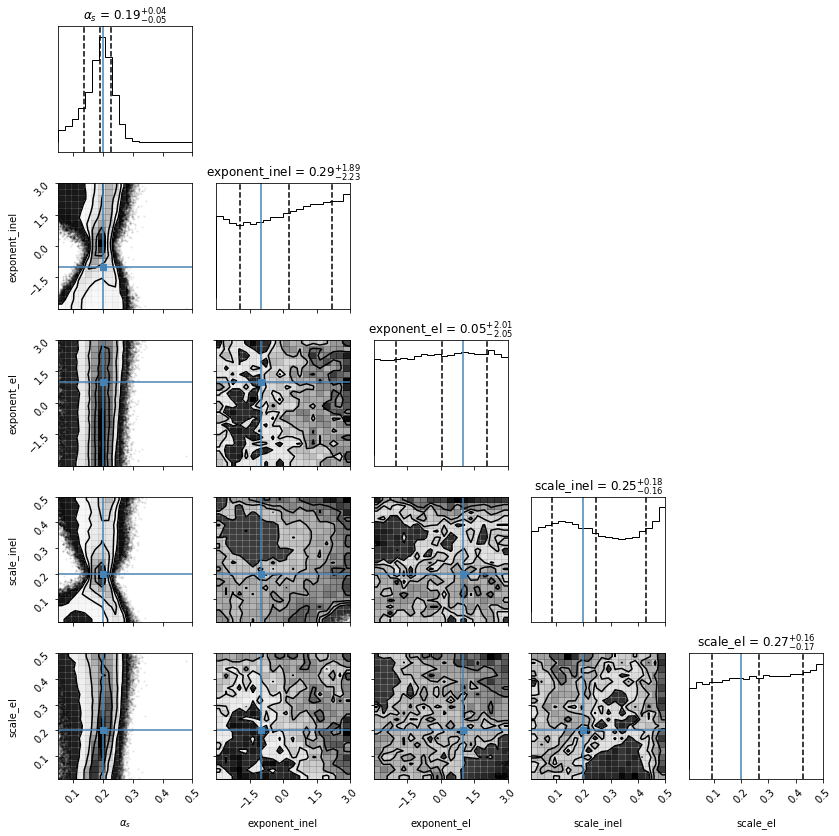

In [99]:
fig = corner.corner(chain, quantiles=[0.16, 0.5, 0.84], truths=truth.T,
                    labels=[r"$\alpha_s$", 'exponent_inel', 'exponent_el','scale_inel','scale_el'], show_titles=True, scale_hist=True,
                    plot_contours=True, range=(prior_ranges.values()));
plt.tight_layout()
plt.savefig('corner-lhsgp-ptemcee.png',dpi=600)
plt.show()

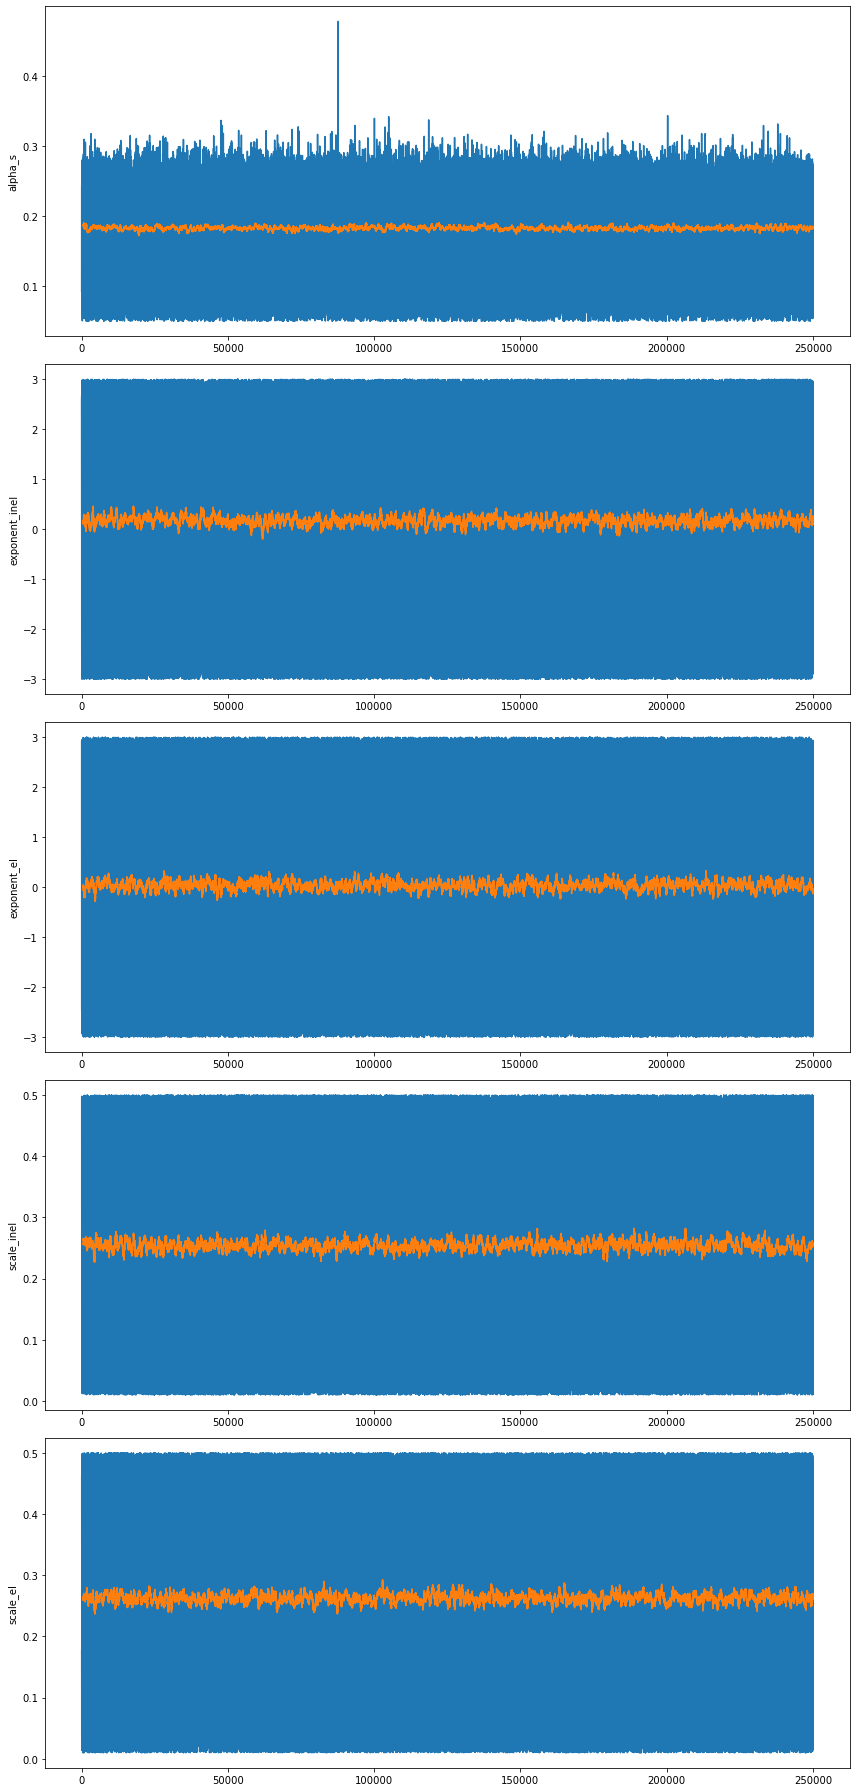

In [100]:
names=list(prior_ranges.keys())
df_chain = pd.DataFrame(chain,columns=names)

fig, ax = plt.subplots(len(names),1,figsize=(12,5*len(names)))

for i in range(len(names)):
    df_chain['ma_'+names[i]] = df_chain[names[i]].rolling(window=500,center=False).mean()

    ax[i].plot(np.arange(chain.shape[0]),chain[:,i],label=names[i])
    ax[i].plot(np.arange(chain.shape[0]),df_chain['ma_'+names[i]],label=r'Moving average')
    ax[i].set_ylabel(names[i])

plt.tight_layout()
plt.savefig('lhsgp-trace-ma.png')
plt.show()

Only thing left is to try to plot the different chains, but we don't have a mutimodal distribution, so we don't need to really worry about mixing.

In [105]:
walker_chain = ptsampler.chain[0, :, :, :]
print(walker_chain.shape)
np.save('walker_chain', walker_chain)
walker_chain=np.load('walker_chain.npy')

(50, 5000, 5)


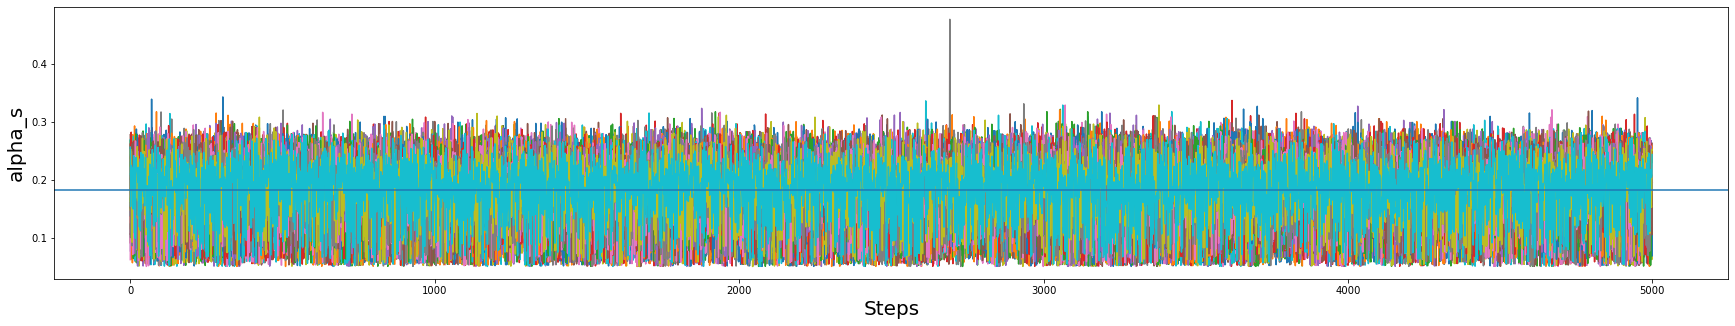

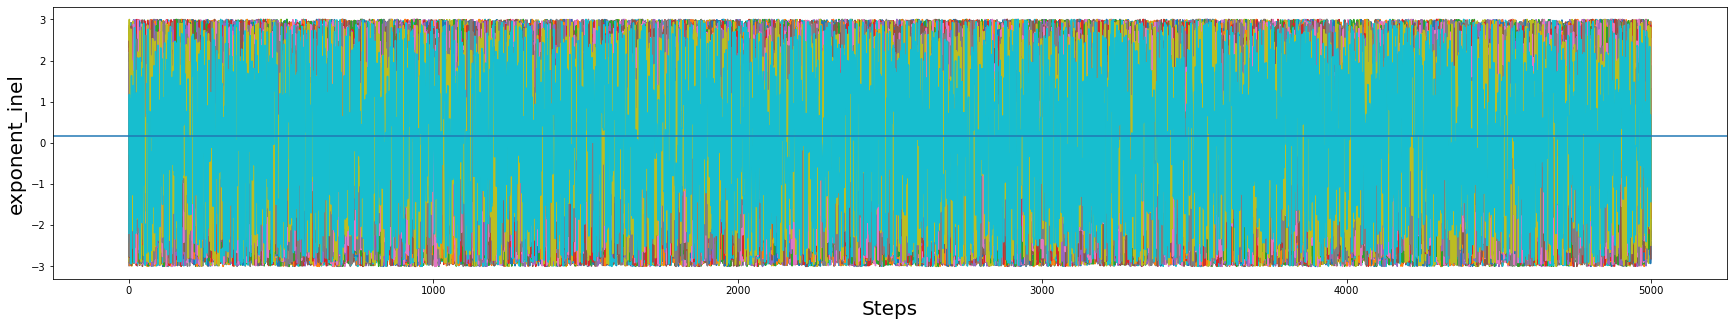

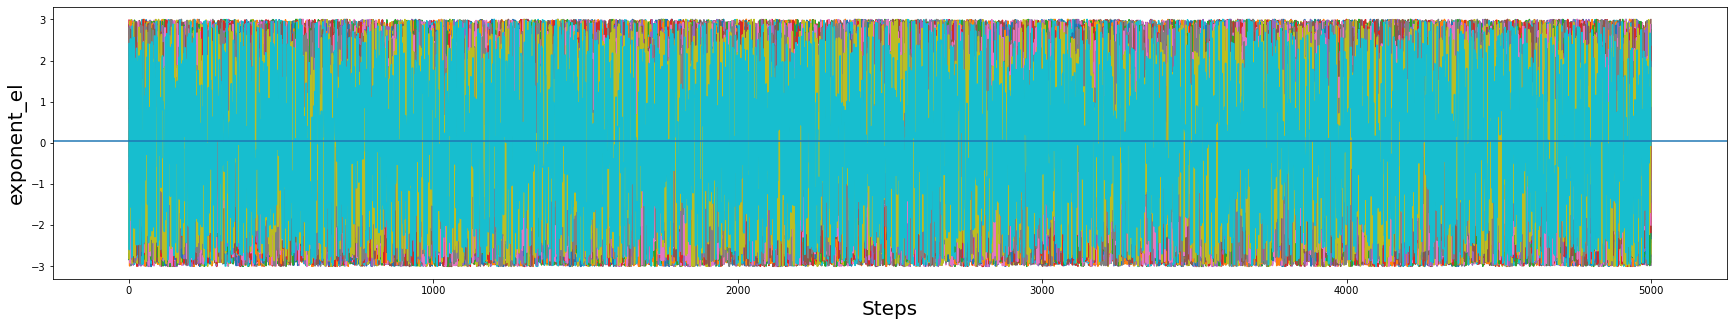

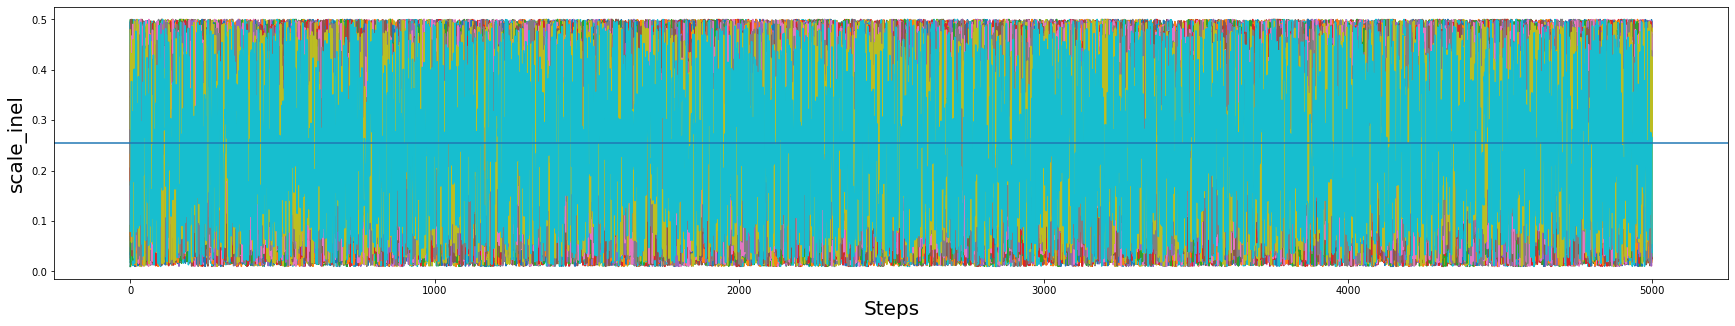

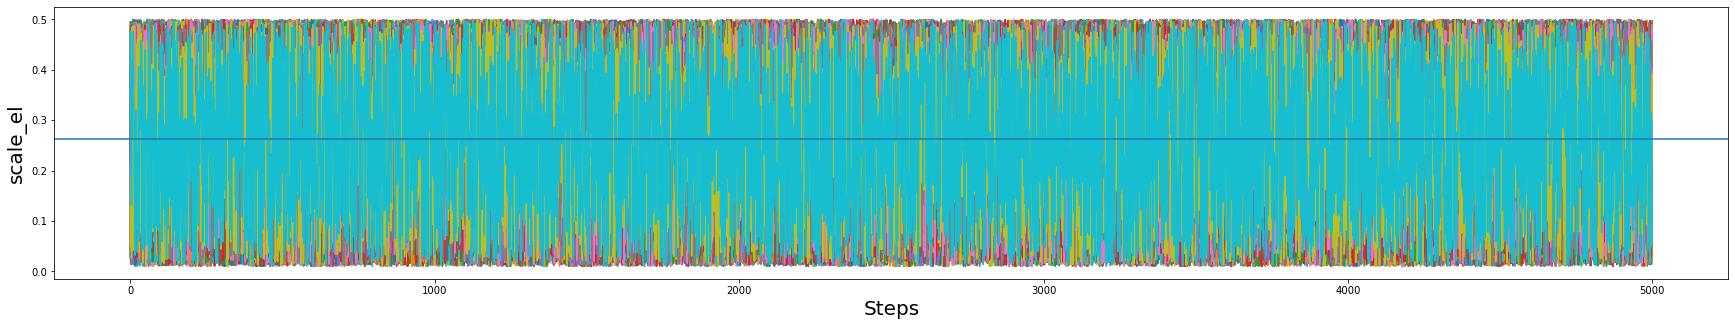

In [108]:
sample_steps = np.arange(0,walker_chain.shape[1])
for p, param in enumerate(names):
    fig, ax = plt.subplots(figsize=(30,5))
    for ch in range(0,walker_chain.shape[0]):
        ax.plot(sample_steps, walker_chain[ch,:,p].flatten(), label=f'chain {ch}')
    
    ax.axhline(y=np.mean(walker_chain[:,:,p]))
    ax.set_xlabel('Steps', fontsize = 20)
    ax.set_ylabel(f'{param}', fontsize = 20)
    #ax.legend()
    
plt.show()